### KNN

En este notebook utilizaremos modelos de KNN para entrenar y clasificar el dataset con distintas configuraciones. Comenzaremos con la función de preprocesamiento que recrea lo realizado en la primera parte del TP, continuaremos con la función `preprocessing_significantes`, y finalizaremos preprocesando con las mejores variables seleccionadas con un árbol de decisión.

In [2]:
# Modelo
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing
import preprocessing
import utils

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import classification_report, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
import numpy as np

Definimos los hiperparámetros que probaremos y sus valores posibles, para la validación cruzada.

In [3]:
params = { 'n_neighbors': range(10,300,5), 'weights': ('uniform', 'distance'), 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': range(1,3) }
model = KNeighborsClassifier()

### Preprocessing base

Comenzamos por entrenar un modelo de KNN bajo las mismas condiciones en las que realizamos el baseline de la primera parte del TP.

In [4]:
df_base = utils.get_data()

In [5]:
gscv_base = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [6]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_base.drop('tiene_alto_valor_adquisitivo',1), df_base['tiene_alto_valor_adquisitivo'], random_state=112)
X_train_base, X_test_base = preprocessing.preprocessing_base_parte_1(X_train_base, X_test_base)

In [14]:
%%time
gscv_base.fit(X_train_base, y_train_base)
score_base = roc_auc_score(y_test_base, gscv_base.predict_proba(X_test_base)[:,1])

Fitting 5 folds for each of 696 candidates, totalling 3480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

CPU times: user 24.6 s, sys: 2.39 s, total: 27 s
Wall time: 36min 37s


In [16]:
gscv_base.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}

In [7]:
knn1 = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=30, p=1, weights='uniform')
knn1.fit(X_train_base, y_train_base)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=30, p=1)

In [17]:
score_base

0.8937630186206427

Vemos un buen resultado en AUC-ROC, veamos cómo dieron las demás métricas

In [18]:
print(classification_report(y_test_base,gscv_base.predict(X_test_base)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6182
           1       0.72      0.58      0.65      1959

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.77      8141
weighted avg       0.84      0.85      0.84      8141



En líneas generales son buenos resultados, con un accuracy equiparable al de la parte 1 de este TP. Lo que sigue siendo bastante pobre es la clasificación de casos de poder adquisitivo alto.

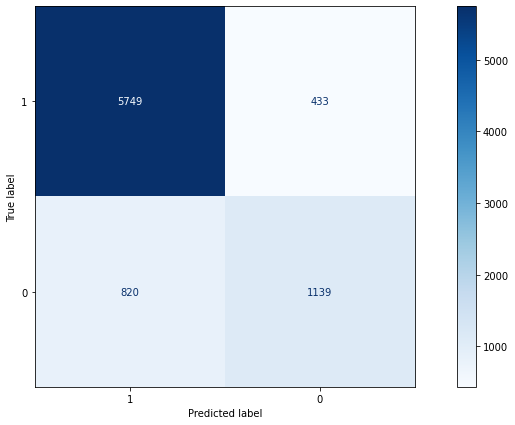

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv_base, X_test_base, y_test_base, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

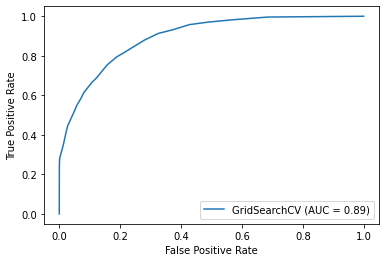

In [20]:
plot_roc_curve(gscv_base, X_test_base, y_test_base)

En general, podemos decir que es un buen clasificador. Veamos si podemos obtener mejores resultados trabajando de forma distinta con el preprocesamiento de los datos.

### Preprocessing Significantes

Repetimos el procedimiento anterior, con otro preprocesamiento.

In [8]:
df = utils.get_data()

In [9]:
params = { 'n_neighbors': range(10,300,20), 'weights': ('uniform', 'distance'), 'algorithm': ['ball_tree', 'kd_tree'], 'p': range(1,3) }
model = KNeighborsClassifier()

In [13]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=2, verbose=5)

In [10]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)
X_train, X_test = preprocessing.preprocessing_significantes(X_train, X_test, 0.9)

/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test[

In [ ]:
%%time
gscv.fit(X_train, y_train)
score = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])

Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 56.4min


In [17]:
gscv.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 2, 'weights': 'uniform'}

In [11]:
knn2 = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=50, p=2, weights='uniform')
knn2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=50)

In [18]:
score

0.8811689043046642

Hay un ligero empeoramiento en la métrica AUC-ROC

In [19]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6182
           1       0.69      0.53      0.60      1959

    accuracy                           0.83      8141
   macro avg       0.77      0.73      0.75      8141
weighted avg       0.82      0.83      0.82      8141



Vemos que en el resto de las métricas los resultados tampoco mejoraron, y algunos de ellos empeoraron. 

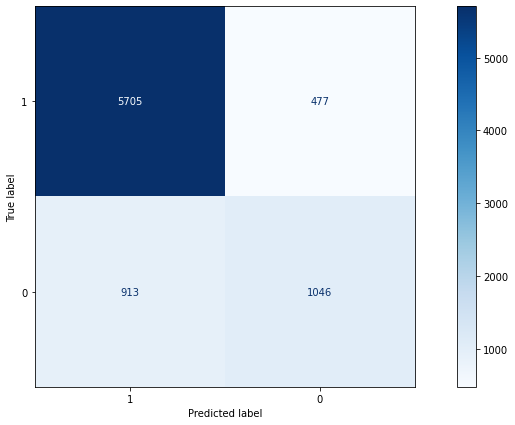

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

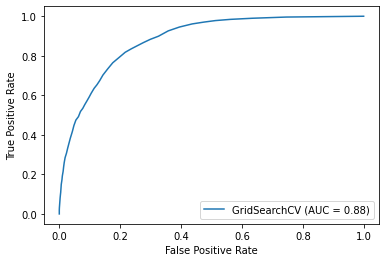

In [21]:
plot_roc_curve(gscv, X_test, y_test)

Vemos que los resultados, si bien no son pésimos, empeoraron respecto del primer caso. Continuemos con el último preprocesamiento que usaremos en este modelo.  

### Mejores variables seleccionadas con un arbol

En línea con lo analizado en el notebook de análisis de preprocessings, entrenaremos un modelo de KNN con las variables seleccionadas usando un árbol de decisión.

In [12]:
df = utils.get_data()

In [13]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)

In [14]:
X_train, X_test = preprocessing.preprocessing_mejores_por_arbol(X_train, X_test)

In [6]:
params = { 'n_neighbors': range(10,200,10), 
          'weights': ('uniform', 'distance'),
          'algorithm': ('ball_tree', 'kd_tree'),
          'p': range(1,3) }

model = KNeighborsClassifier()

gscv1 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=2, verbose = 5)

In [7]:
%%time
gscv1.fit(X_train, y_train)

Fitting 2 folds for each of 152 candidates, totalling 304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:  2.7min finished


CPU times: user 2.28 s, sys: 159 ms, total: 2.44 s
Wall time: 2min 40s


GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('ball_tree', 'kd_tree'),
                         'n_neighbors': range(10, 200, 10), 'p': range(1, 3),
                         'weights': ('uniform', 'distance')},
             scoring='roc_auc', verbose=5)

#### El mejor modelo:

In [8]:
print(gscv1.best_estimator_)
print(gscv1.best_params_)
print(gscv1.best_score_)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=30, p=1)
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
0.8971692870565653


Obtuvimos un modelo bastante similar al anterior, por lo que no sería esperable que haya una mejora considerable en las métricas que nos interesa analizar.

In [15]:
knn3 = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=30, p=1, weights='uniform')
knn3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=30, p=1)

In [10]:
print(classification_report(y_test,gscv1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6182
           1       0.75      0.58      0.65      1959

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



Efectivamente, obtuvimos resultados que no difieren en gran medida de lo obtenido anteriormente. 

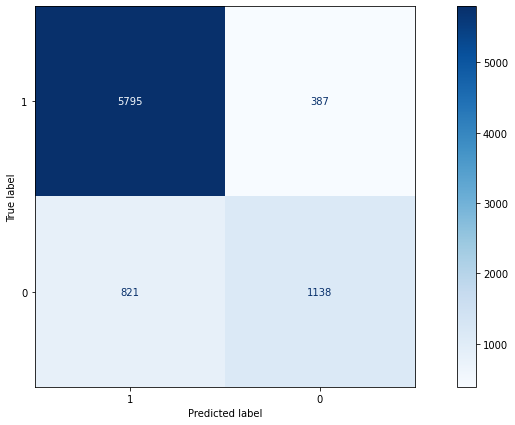

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv1, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

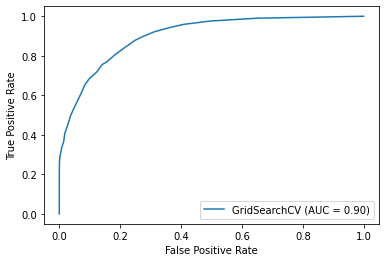

In [15]:
plot_roc_curve(gscv1, X_test, y_test)

Vemos que, de los tres modelos entrenados, el último es el que mejores resultados tuvo, si bien esos resultados no distan en gran medida de los demás. Podemos atribuirle esta mejora en los resultados a la selección de variables realizada en el preprocesamiento.

# Persistiendo los modelos

In [16]:
import pickle

In [17]:
pickle.dump(knn1, open("Modelos/KNN/knn1.pickle", "wb"))
pickle.dump(knn2, open("Modelos/KNN/knn2.pickle", "wb"))
pickle.dump(knn3, open("Modelos/KNN/knn3.pickle", "wb"))